In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import xarray as xr

import kdephys.hypno as kh
import kdephys.pd as kpd
import kdephys.xr as kx
import kdephys.utils as ku
import kdephys.ssfm as ss

import acr.subjects as subs
import acr
import plotly.express as px
import plotly.io as pio

/home/kdriessen/github_t2/kdephys/kdephys/xr/utils.py:4: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
a4_info = {}
a4_info["subject"] = "ACR_4"
a4_info["complete_key_list"] = ["control1-sd", "control1-bl", "laser1-bl", "laser1-sd", "laser1", "control1"]
a4_info["paths"] = acr.io.get_acr_paths(a4_info["subject"], a4_info["complete_key_list"])
a4_info["times"] = {}

a4_info["load_times"] = {}
a4_info["load_times"]["control1-sd"] = (0, 6)
a4_info["load_times"]["laser1-sd"] = (0, 6)
a4_info["load_times"]["control1-bl"] = (60000, 6)
a4_info["load_times"]["laser1-bl"] = (60000, 6)
a4_info["load_times"]["control1"] = (0, 6)
a4_info["load_times"]["laser1"] = (0, 6)
a4_info["channels"] = {}
a4_info["channels"]["EEGr"] = [3, 4]
a4_info["channels"]["EMGr"] = [1, 2]

In [3]:
d, s, b = acr.io.acr_load_master(a4_info, stores=["EEGr"], type='pandas', hyp=False)

read from t=0s to t=21600.0s
Using 610.3516 Hz as SEV sampling rate for EEGr
read from t=60000s to t=86617.83s
Using 610.3516 Hz as SEV sampling rate for EEGr
read from t=60000s to t=86492.39s
Using 610.3516 Hz as SEV sampling rate for EEGr
read from t=0s to t=21600.0s
Using 610.3516 Hz as SEV sampling rate for EEGr
read from t=0s to t=29355.41s
Using 610.3516 Hz as SEV sampling rate for EEGr
read from t=0s to t=22227.97s
Using 610.3516 Hz as SEV sampling rate for EEGr


In [4]:
class data_dict(dict):
    def __init__(self, dict):
        self._dict = dict

    def __getattr__(self, attr):
        if attr in self.__dict__:
            return getattr(self, attr)
        return getattr(self._dict, attr)

    def __getitem__(self, item):
        return self._dict[item]

    def __setitem__(self, item, data):
        self._dict[item] = data

    def __repr__(self):
        return repr(self._dict)

    def __len__(self):
        return len(self._dict)

    def mush(self):
         df_list = []
         for k in self._dict.keys():
            df_list.append(self._dict[k])
         return pd.concat(df_list)

In [259]:
bb = data_dict(b)

In [260]:
bp = bb.mush()

In [261]:
bp['gamma'] = bp['low_gamma'] + bp['high_gamma']

In [262]:
bp = bp.reset_index(drop=False).set_index(["datetime", "channel", "condition"])
#bp = bp[np.logical_and(bp.low_gamma < out3, bp.low_gamma < out4)]
bp3 = bp.xc(3).reset_index()
bp4 = bp.xc(4).reset_index()

In [263]:
out3 = np.percentile(bp3.gamma.values, 98.5)
#bp3 = bp3[bp3.gamma.values < out3]
bp3.loc[bp3.gamma.values > out3, "gamma"] = np.nan

In [264]:
out4 = np.percentile(bp4.gamma.values, 98.5)
#bp4 = bp4[bp4.gamma.values < out4]
bp4.loc[bp4.gamma.values > out4, "gamma"] = np.nan

In [265]:
g3 = bp3.gamma.values
c3 = bp3.condition.values
gch3 = pd.DataFrame({"gamma": g3, "condition": c3})
g4 = bp4.gamma.values
c4 = bp4.condition.values
gch4 = pd.DataFrame({"gamma": g4, "condition": c4}) 

# Grant Plot

In [266]:
cbl = gch3[gch3.condition == "control1-bl-EEGr"]
csd = gch3[gch3.condition == "control1-sd-EEGr"]
crc = gch3[gch3.condition == "control1-EEGr"]
gch3_ctrl = pd.concat([cbl, csd, crc]).reset_index()
lbl = gch3[gch3.condition == "laser1-bl-EEGr"]
lsd = gch3[gch3.condition == "laser1-sd-EEGr"]
lrc = gch3[gch3.condition == "laser1-EEGr"]
gch3_las = pd.concat([lbl, lsd, lrc]).reset_index()

csd_mean3 = csd.gamma.mean()
gch3_las['gamma_rel'] = gch3_las.gamma/csd_mean3

In [267]:
gch3_las[gch3_las.condition == "laser1-sd-EEGr"]

,index,gamma,condition,gamma_rel
10796,30432,2430.612793,laser1-sd-EEGr,1.218625
10797,30433,1871.406006,laser1-sd-EEGr,0.938258
10798,30434,2533.453125,laser1-sd-EEGr,1.270186
10799,30435,2363.600586,laser1-sd-EEGr,1.185028
10800,30436,2511.985352,laser1-sd-EEGr,1.259423
...,...,...,...,...
19716,39352,2888.601074,laser1-sd-EEGr,1.448245
19717,39353,2408.832764,laser1-sd-EEGr,1.207705
19718,39354,2503.024414,laser1-sd-EEGr,1.254930
19719,39355,2188.282715,laser1-sd-EEGr,1.097129


In [268]:
cbl = gch4[gch4.condition == "control1-bl-EEGr"]
csd = gch4[gch4.condition == "control1-sd-EEGr"]
crc = gch4[gch4.condition == "control1-EEGr"]
gch4_ctrl = pd.concat([cbl, csd, crc]).reset_index()
lbl = gch4[gch4.condition == "laser1-bl-EEGr"]
lsd = gch4[gch4.condition == "laser1-sd-EEGr"]
lrc = gch4[gch4.condition == "laser1-EEGr"]
gch4_las = pd.concat([lbl, lsd, lrc]).reset_index()

csd_mean4 = csd.gamma.mean()

gch4_las['gamma_rel'] = gch4_las.gamma/csd_mean4

In [269]:
gch4_las[gch4_las.condition == "laser1-sd-EEGr"]

,index,gamma,condition,gamma_rel
10796,30432,2442.110596,laser1-sd-EEGr,1.267240
10797,30433,1533.222168,laser1-sd-EEGr,0.795607
10798,30434,2249.124023,laser1-sd-EEGr,1.167097
10799,30435,1690.889160,laser1-sd-EEGr,0.877422
10800,30436,1992.954102,laser1-sd-EEGr,1.034167
...,...,...,...,...
19716,39352,2088.914551,laser1-sd-EEGr,1.083962
19717,39353,1391.576904,laser1-sd-EEGr,0.722106
19718,39354,1770.723877,laser1-sd-EEGr,0.918849
19719,39355,1561.463867,laser1-sd-EEGr,0.810262


In [279]:
gch3_las['gamma_norm'] = gch3_las.gamma+200
gch4_las['gamma_norm'] = gch4_las.gamma+200

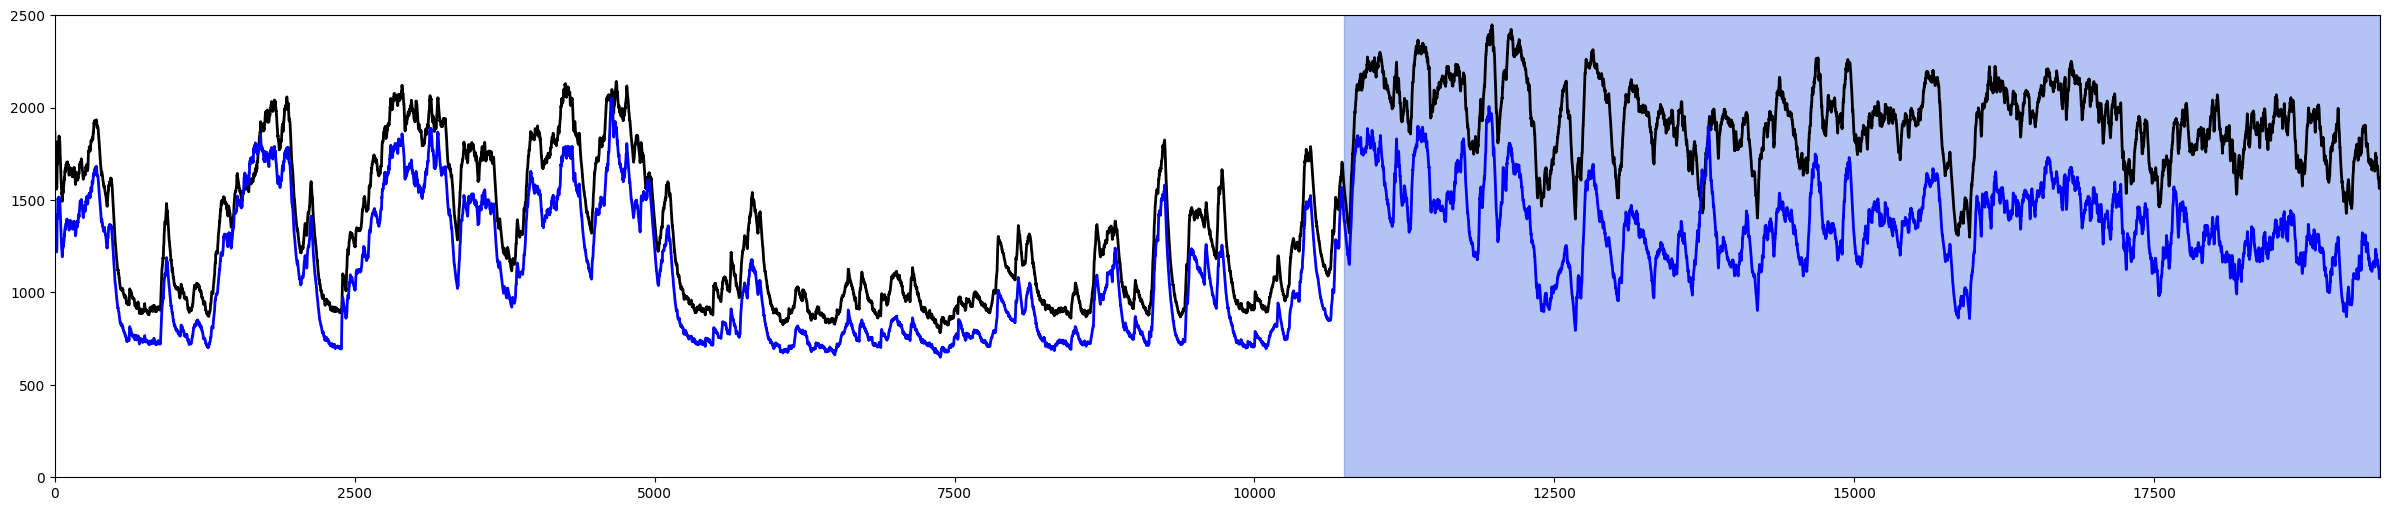

In [282]:
f, ax = plt.subplots(1, 1, figsize=(30, 6))

# Setting the values for all axes.
custom_ylim = (0, 2500)
custom_xlim = (0, 19382)
plt.setp(ax, ylim=custom_ylim, xlim=custom_xlim)

gch3_las.gamma.ewm(span=100).mean().plot(color='k', linewidth=2)
gch4_las.gamma.ewm(span=100).mean().plot(color='b', linewidth=2)
ax.axvspan(10750, 19382, alpha=0.4, color='royalblue')

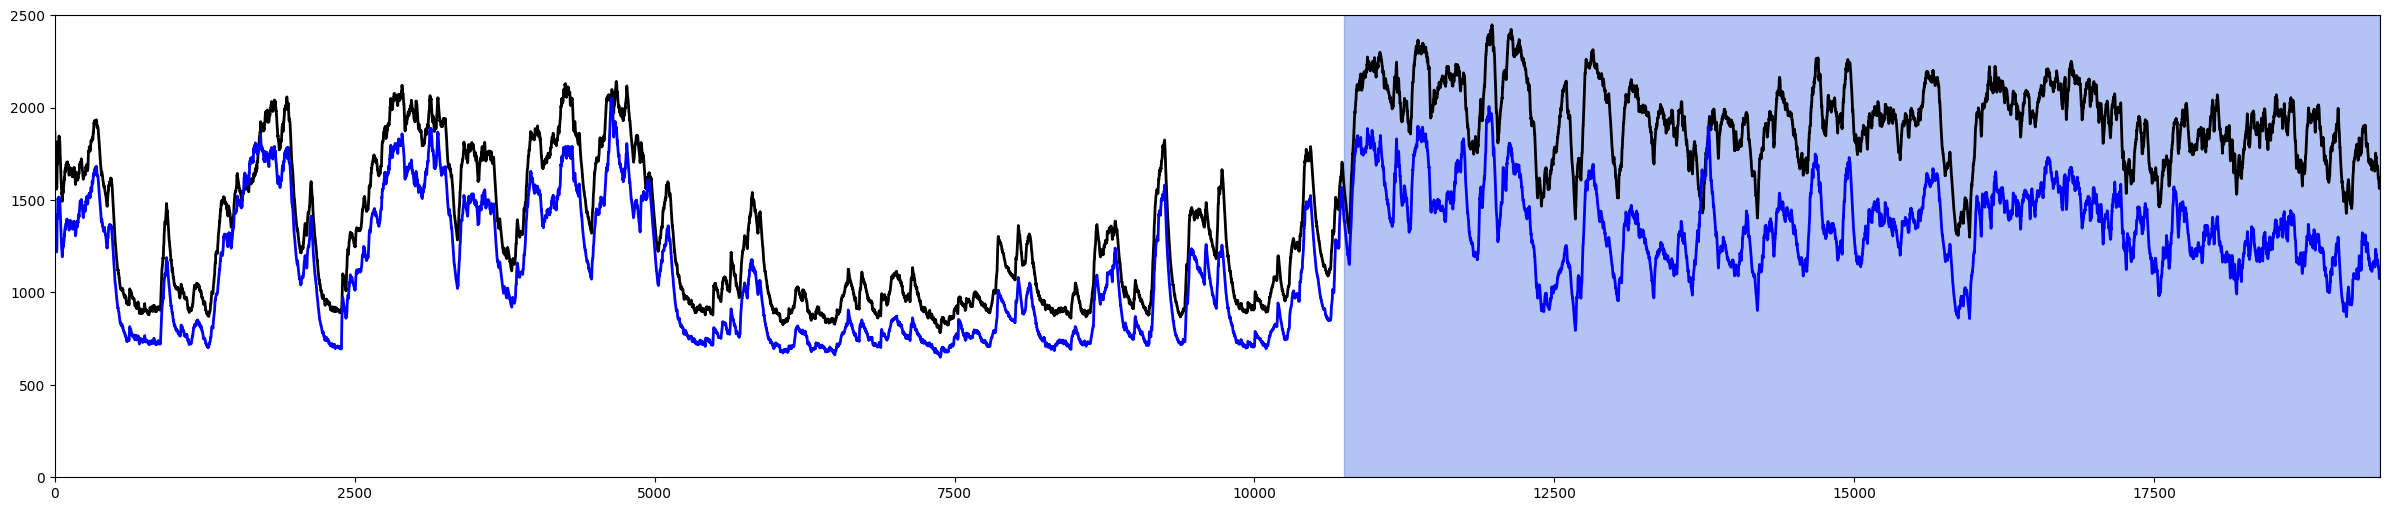

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(30, 6))

# Setting the values for all axes.
custom_ylim = (0, 2500)
custom_xlim = (0, 19382)
plt.setp(ax, ylim=custom_ylim, xlim=custom_xlim)

gch3_las.gamma.ewm(span=100).mean().plot(color='k', linewidth=2)
gch4_las.gamma.ewm(span=100).mean().plot(color='b', linewidth=2)
ax.axvspan(10750, 19382, alpha=0.4, color='royalblue')

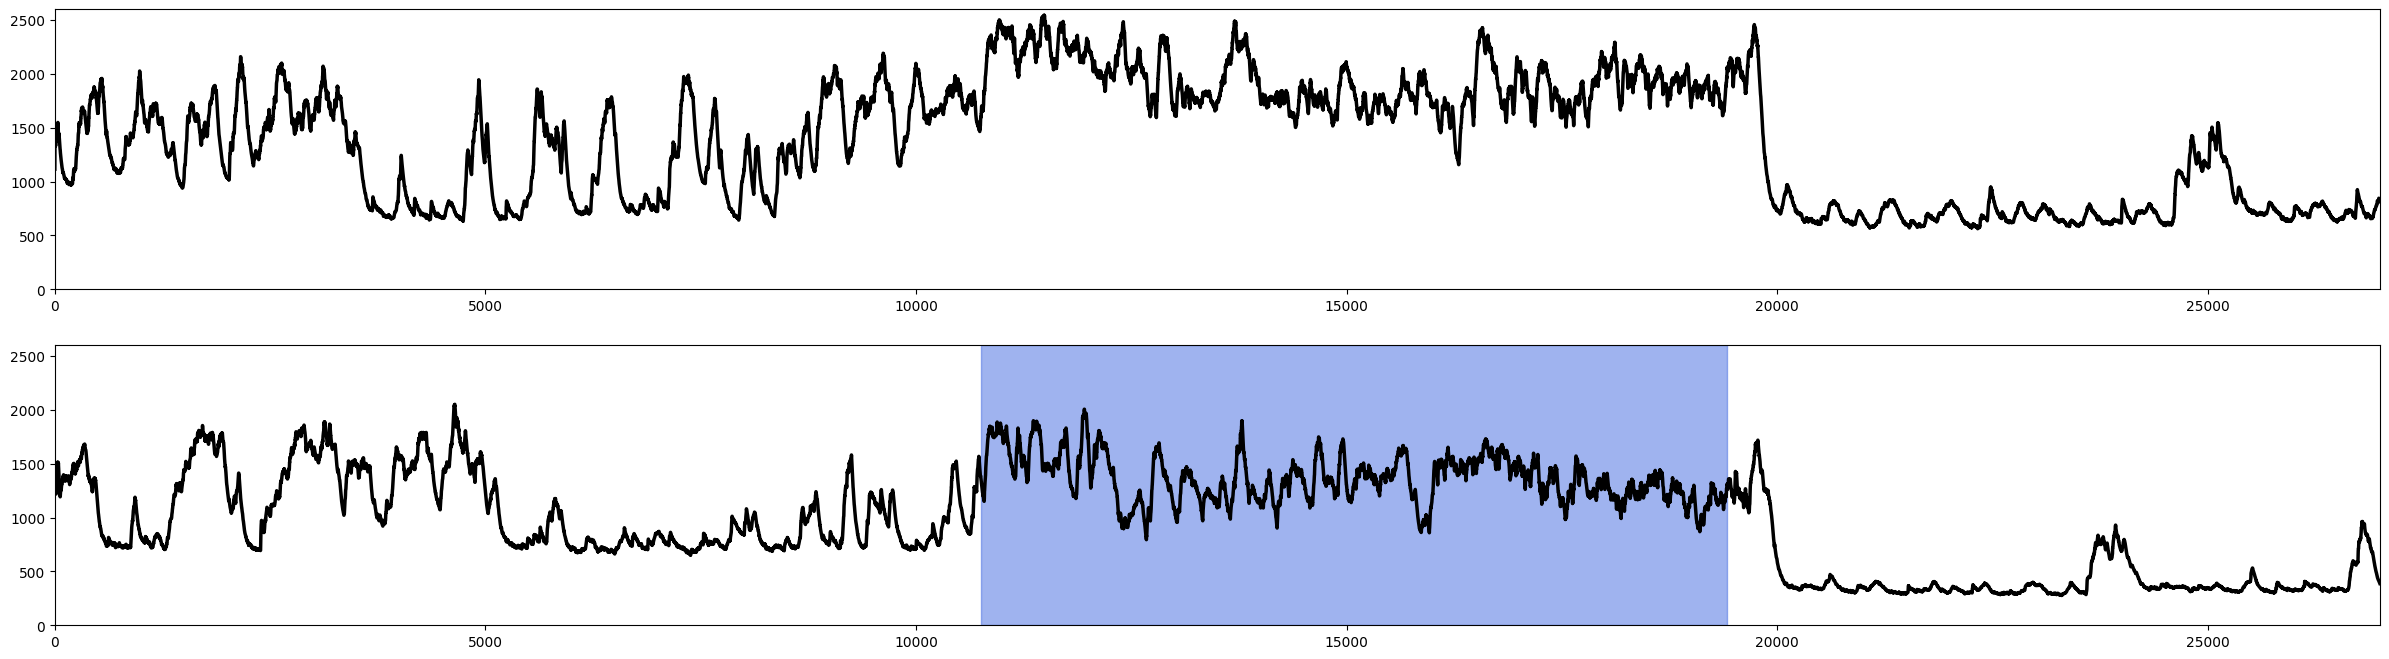

In [295]:
f, ax = plt.subplots(2, 1, figsize=(30, 8))

# Setting the values for all axes.
custom_ylim = (0, 2600)
custom_xlim = (0, 27000)
plt.setp(ax, ylim=custom_ylim, xlim=custom_xlim)

gch4_ctrl.gamma.ewm(span=100).mean().plot(color='k', linewidth=2.5, ax=ax[0])
gch4_las.gamma.ewm(span=100).mean().plot(color='k', linewidth=2.5, ax=ax[1])
ax[1].axvspan(10750, 19415, alpha=0.5, color='royalblue')

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(30, 10))

# Setting the values for all axes.
custom_ylim = (0, 1500)
plt.setp(ax, ylim=custom_ylim)

gch4_ctrl.gamma.ewm(span=50).mean().plot(ax=ax[0], color='k')
gch4_las.gamma.ewm(span=50).mean().plot(ax=ax[1], color='k')
ax[1].axvspan(10756, 19563, alpha=0.5, color='blue')

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(35, 20))


custom_ylim = (0, 1800)

# Setting the values for all axes.
plt.setp(ax, ylim=custom_ylim)

gch4.gamma[gch4.condition == "control1-bl-EEGr"].ewm(span=50).mean().plot(ax=ax[0, 0], color='k')
gch4.gamma[gch4.condition == "control1-sd-EEGr"].ewm(span=50).mean().plot(ax=ax[0, 1], color='k')
gch4.gamma[gch4.condition == "control1-EEGr"].ewm(span=50).mean().plot(ax=ax[0, 2], color='k')

gch4.gamma[gch4.condition == "laser1-bl-EEGr"].ewm(span=50).mean().plot(ax=ax[1, 0], color='b')
gch4.gamma[gch4.condition == "laser1-sd-EEGr"].ewm(span=50).mean().plot(ax=ax[1, 1], color='b')
gch4.gamma[gch4.condition == "laser1-EEGr"].ewm(span=50).mean().plot(ax=ax[1, 2], color='b')


We'll look at two of ACR_4's SD experiments. Both were 5 hours, but in one the laser was on continuously, delivering photoinhibition, near EEG channels 2 and 4. 

Channels 1 and 3 were contralateral to the channels near the photoinhibition site:

![](ref/acr4_schematic.png)

Gamma bandpower distributions over the entire 5-hr SD:

In [ ]:
px.histogram(bp, x='low_gamma', color='condition', color_discrete_sequence=['black', 'royalblue'], marginal='box', barmode='overlay', facet_col='channel', facet_col_wrap=1)

Gamma bandpower over the entire 5-hr SD:

In [ ]:
px.line(bp, x="time", y="low_gamma", color="condition", facet_row="channel", width=1800, height=1200, color_discrete_sequence=['black', 'royalblue'])

Smoothing out each channel and looking at it over time:

In [ ]:
pio.templates.default = "plotly_white"

Channel-1:

In [ ]:
px.line(bp.ch(1).sm('low_gamma', sigma=10), x="time", y="low_gamma_smooth", color="condition", width=1800, height=600, color_discrete_sequence=['black', 'royalblue'])

Channel-2:

In [ ]:
px.line(bp.ch(2).sm('low_gamma', sigma=10), x="time", y="low_gamma_smooth", color="condition", width=1800, height=600, color_discrete_sequence=['black', 'royalblue'])

Channel-3:

In [ ]:
px.line(bp.ch(3).sm('low_gamma', sigma=10), x="time", y="low_gamma_smooth", color="condition", width=1800, height=600, color_discrete_sequence=['black', 'royalblue'])

Channel-4:

In [ ]:
px.line(bp.ch(4).sm('low_gamma', sigma=10), x="time", y="low_gamma_smooth", color="condition", width=1800, height=600, color_discrete_sequence=['black', 'royalblue'])

# Pandas Smoothing

In [ ]:
import tdt
import xarray as xr
from scipy.stats import mode
from scipy.ndimage.filters import gaussian_filter1d
import numpy as np
import pandas as pd

# Misc utils for dealing with xarray structures:
def gaussian_smooth(data, sigma, sampling_frequency, axis=0, truncate=8):
    """1D convolution of the data with a Gaussian.

    The standard deviation of the gaussian is in the units of the sampling
    frequency. The function is just a wrapper around scipy's
    `gaussian_filter1d`, The support is truncated at 8 by default, instead
    of 4 in `gaussian_filter1d`

    Parameters
    ----------
    data : array_like
    sigma : float
    sampling_frequency : int
    axis : int, optional
    truncate : int, optional

    Returns
    -------
    smoothed_data : array_like

    """

    return gaussian_filter1d(
        data, sigma * sampling_frequency, truncate=truncate, axis=axis, mode="constant"
    )


def estimate_fs(da):
    sample_period = mode(np.diff(da.datetime.values), keepdims=True).mode[0]
    assert isinstance(sample_period, np.timedelta64)
    sample_period = sample_period / pd.to_timedelta(1, "s")
    return 1 / sample_period


def get_smoothed_da(da, smoothing_sigma=10, in_place=False):
    if not in_place:
        da = da.copy()
    da.values = gaussian_smooth(da, smoothing_sigma, estimate_fs(da))
    return da


def get_smoothed_ds(ds, smoothing_sigma=10, in_place=False):
    if not in_place:
        ds = ds.copy()
    for da_name, da in ds.items():
        ds[da_name] = get_smoothed_da(da, smoothing_sigma, in_place)
    return ds

In [ ]:
t = bp.copy()

In [ ]:
def get_smoothed_df(df, smoothing_sigma=10, in_place=False, exclude = ['time', 'timedelta']):
    ix_final = list(df.index.names)
    for x in exclude:
        if x not in ix_final:
            ix_final.append(x)

    df_sm = df.reset_index().set_index(ix_final)
    sm_vals = {}
    for col in 

    if not in_place:
        da = da.copy()
    da.values = gaussian_smooth(da, smoothing_sigma, estimate_fs(da))
    return da

In [ ]:
ts = get_smoothed_df(t, smoothing_sigma=10, in_place=False, exclude = ['time', 'timedelta'])

In [ ]:
bl4 = ts.xs('control1-bl-EEGr', level='condition').xs(4, level='channel')

In [ ]:
bl = ts.xs('control1-bl-EEGr', level='condition')


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(35, 10))
bl4['low_gamma'].plot(color='lightgray', linewidth = 0.5)
bl4['low_gamma'].ewm(span=15).mean().plot(color='r', linewidth = 3)


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(35, 10))
bl.xc(4)['low_gamma'].plot(color='lightgray', linewidth = 0.5)
bl.xc(4)['low_gamma'].ewm(span=15).mean().plot(color='r', linewidth = 3)

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(35, 10))
bl.xc(2)['low_gamma'].plot(color='lightgray', linewidth = 0.5)
bl.xc(2)['low_gamma'].ewm(span=15).mean().plot(color='r', linewidth = 3)